# Übung 2: Gauss-Klassifikator - Rainier Robles & Valentin Wolf

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Import & visualise the data

In [2]:
train = pd.read_table('zip.train', delim_whitespace=True,header=None)
test = pd.read_table('zip.test', delim_whitespace=True,header=None)

In [3]:
train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,6.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.631,0.862,...,0.304,0.823,1.000,0.482,-0.474,-0.991,-1.000,-1.000,-1.000,-1.0
1,5.0,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,...,-0.671,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0
2,4.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-0.109,1.000,-0.179,-1.000,-1.000,-1.000,-1.0


In [4]:
#train = train[(train[0]==7)|(train[0]==8)]
#test = test[(test[0]==7)|(test[0]==8)]
#split labels y from data X
y_train = train[0].as_matrix()
y_test = test[0].as_matrix()
X_train = train.drop(0, axis=1).as_matrix()
X_test = test.drop(0, axis=1).as_matrix()

(-0.5, 15.5, 15.5, -0.5)

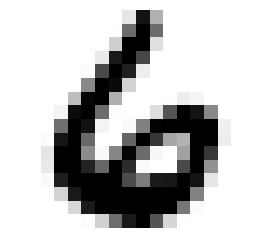

In [5]:
img = X_train[0,:].reshape(16,16)
im = plt.imshow(img, cmap='Greys')
plt.axis('off')

In [6]:
def is_invertible(X):
    return np.linalg.cond(X) < 1 / np.spacing(1)

### Define the Classifier

In [7]:
class Classifier(object):
    def error_rate(self,truth, pred):
        """gets two vectors, returns (correct classified / total classified)"""
        amount = truth.shape[0]
        wrong = np.count_nonzero(truth - pred)
        return wrong/amount
    
    def accuracy(self,truth,pred):
        return np.mean(truth == pred)
    
def confused_matrix(x,y,percentage=False):
    assert(x.shape == y.shape)
    num_entries = x.shape[0]
    matrix = np.zeros((10,10))
    for i in range(num_entries):
        matrix[int(x[i]),int(y[i])] += 1
    if percentage==True: 
        matrix /= np.sum(matrix,axis=1)
    return matrix


In [8]:
class GaussClassifier(Classifier):
    def fit(self,X,y):
        self.classes = np.unique(y)
        classes_count = len(self.classes)
        features = X.shape[1]
        self.centers = np.zeros((classes_count,features))
        self.pinv_covs = np.zeros((classes_count,features,features))
        self.dets = np.zeros(classes_count)
        
        
        for i in range(classes_count):
            cls = self.classes[i]
            X_class = X[y == cls]
            N = X_class.shape[0]
            self.centers[i] = np.mean(X_class,axis=0)
            X_class -= self.centers[i]
            cov = 1/N * np.sum((X_class[...,None] * X_class[:,None]),axis=0) 
            #https://stackoverflow.com/questions/40413000/column-by-row-multiplication-in-numpy
            self.pinv_covs[i] = np.linalg.pinv(cov)
            
            self.dets[i] = 1/np.sqrt(np.linalg.norm((2*np.pi)*cov))
            
            
    def predict(self,X):
        classes_count = len(self.classes)
        scores = np.zeros((X.shape[0],classes_count))

        for i in range(X.shape[0]):
            for j in range(classes_count):
                Xi_centered = X[i] - self.centers[j]
                expo = (-0.5)*np.dot(np.dot(Xi_centered.T,self.pinv_covs[j]),Xi_centered)
                scores[i,j] = self.dets[j] * np.exp(expo)
                
        best_scores = np.argmax(scores,axis=1)
        # np.argmax gives us the index of our predicted label in classes
        # so the actual label is in self.classes[index]
        f = lambda x: self.classes[x]
        labels = np.fromiter((f(xi) for xi in best_scores), best_scores.dtype)
        
        return labels 

In [32]:
class_center = np.mean(X_test[y_test == 0],axis=0)
X_class = X_test[y_test == 0] - class_center
(X_class - class_center).T.dot((X_class - class_center)).shape

(256, 256)

In [33]:
#cov = (X_class[...,None] * X_class[:,None])
cov2 = np.sum((X_class[...,None] * X_class[:,None]),axis=0) / 359
np.cov(X_train[y_train==0].T,bias=1).mean()

0.03125414468315825

In [34]:
cov2.mean()

0.035931547930312065

# Fit & All vs All Predict

In [20]:
classifier = GaussClassifier()

classifier.fit(X_train, y_train)

In [21]:
pred = classifier.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


In [22]:
print('Accuracy:', round(classifier.accuracy(y_test,pred),5),
      '\nError rate:', round(classifier.error_rate(y_test,pred),5))

Accuracy: 0.84405 
Error rate: 0.15595


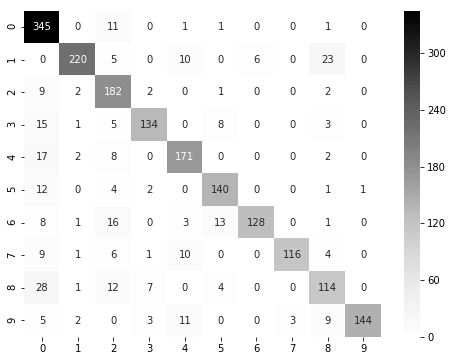

In [23]:
x = confused_matrix(y_test,pred)
dims = (8, 6)
fig, ax = plt.subplots(figsize=dims)
sns.heatmap(ax=ax,data=x, annot=True, fmt="g", cmap='Greys')

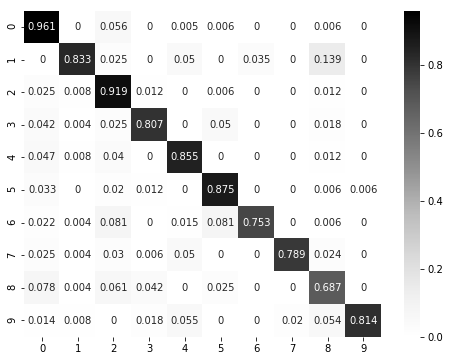

In [15]:
x = confused_matrix(y_test,pred,percentage=True)
dims = (8, 6)
fig, ax = plt.subplots(figsize=dims)
sns.heatmap(ax=ax,data=np.round(x,3), annot=True, fmt="g", cmap='Greys')

# 1 vs. 1 Prediction

In [16]:
array = [3,5,7,8] #range(10)

for i in array:
    for j in array:
        if i >= j:
            continue
        X_tr = X_train[(y_train==i)|(y_train==j)]
        y_tr = y_train[(y_train==i)|(y_train==j)]
        X_te = X_test[(y_test==i)|(y_test==j)]
        y_te = y_test[(y_test==i)|(y_test==j)]
        
        classifier = GaussClassifier()

        classifier.fit(X_tr, y_tr)
        
        pred = classifier.predict(X_te)
        
        print(i, 'vs.', j, 
              'Accuracy:', round(classifier.accuracy(y_te,pred),4), 
              'Error rate:', round(classifier.error_rate(y_te,pred),4))

3 vs. 5 Accuracy: 0.9233 Error rate: 0.0767
3 vs. 7 Accuracy: 0.9297 Error rate: 0.0703
3 vs. 8 Accuracy: 0.8434 Error rate: 0.1566
5 vs. 7 Accuracy: 0.9316 Error rate: 0.0684
5 vs. 8 Accuracy: 0.8742 Error rate: 0.1258
7 vs. 8 Accuracy: 0.8371 Error rate: 0.1629
